Now we solve the Klein-Gordon equation for $x > 0$ and $t > 0$ with the initial
conditions
\begin{equation}
    u(x, 0) = u_t(x, 0) = 0,
\end{equation}
and the boundary condition
\begin{equation}
    u(0, t) = \sin(\omega_0t).
\end{equation}
Physically, this describes a system which is undisturbed $u \equiv 0$ for $t < 0$, but excited for $t > 0$ by a time-harmonic forcing applied at $x = 0$. As before, there is no loss of generality in taking $c_0 = 1$.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def solve_signalling_problem(L, T, q, w0, Nx, Nt):
    '''
    Solves the Klein-Gordon equation for the signalling problem.
    - Initial conditions: u(x,0) = 0, u_t(x,0) = 0
    - Boundary condition: u(0,t) = sin(w0*t)
    '''
    # Setup grids
    dx = L / (Nx - 1)
    dt = T / (Nt - 1)
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T, Nt)
    r = dt / dx

    if r > 1:
        print(f"Stability condition not met. r = {r:.2f} > 1")

    # 2. Initialise solution array to zeros for the new initial conditions
    u = np.zeros((Nt, Nx))

    # 3. Apply boundary and initial conditions
    # u(x,0) = 0 and u_t(x,0)=0 are already handled by the zero initialization.
    # The first time step u[1,:] will also be zero except at the boundary.

    # Main loop for time evolution
    for j in range(1, Nt - 1):
        # Update interior points
        for i in range(1, Nx - 1):
            term_xx = r**2 * (u[j, i+1] - 2*u[j, i] + u[j, i-1])
            term_q = (dt**2 * q**2) * 0.5 * (u[j, i+1] + u[j, i-1])
            u[j+1, i] = 2*u[j, i] - u[j-1, i] + term_xx - term_q

        # Apply boundary conditions for the next step
        # Inner boundary (forcing term)
        u[j+1, 0] = np.sin(w0 * t[j+1])
        # Outer boundary (zero displacement, assuming L is large enough)
        u[j+1, -1] = 0.0

    return x, t, u

def analytical_q0(x, t, w0):
    '''Analytical solution for the standard wave equation (q=0).'''
    return np.where(t >= x, np.sin(w0 * (t - x)), 0)

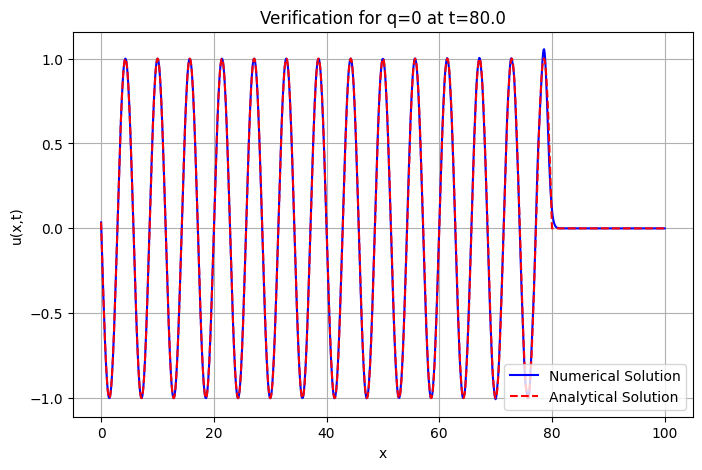

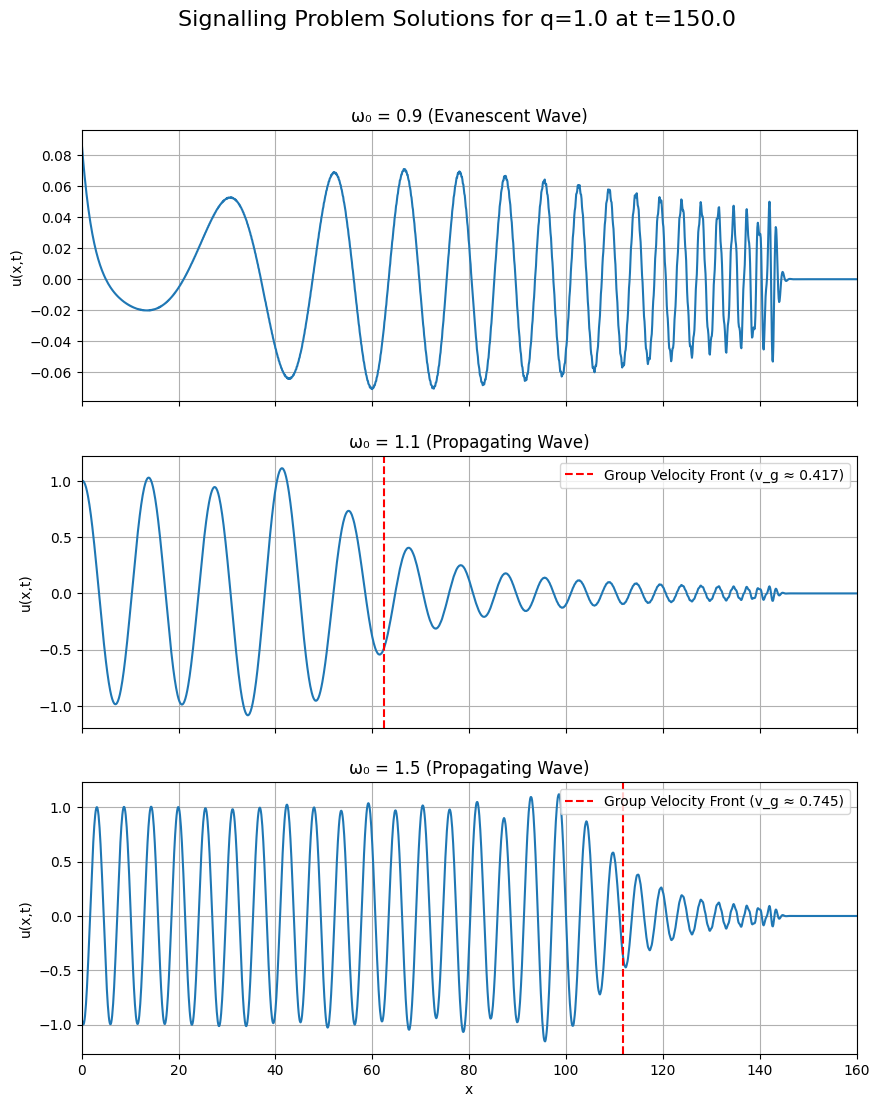

In [6]:
# Verify the program with the analytical solution for q=0
x_check, t_check, u_numerical_q0 = solve_signalling_problem(L=100, T=80, q=0, w0=1.1, Nx=1001, Nt=1601)
t_snapshot = 80.0
t_idx = np.abs(t_check - t_snapshot).argmin()
u_analytical = analytical_q0(x_check, t_check[t_idx], w0=1.1)

plt.figure(figsize=(8, 5))
plt.plot(x_check, u_numerical_q0[t_idx, :], 'b-', label='Numerical Solution')
plt.plot(x_check, u_analytical, 'r--', label='Analytical Solution')
plt.title(f'Verification for q=0 at t={t_snapshot:.1f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()

#  Run simulations for q=1 with different forcing frequencies
# L=200: To ensure signal doesn't reach the end by T=150 (max speed is 1).
# Δx=0.1, Δt=0.05 (r=0.5): Ensures stability and accurately resolves the
# shortest wavelength (for ω₀=1.5, λ=5.6).
L_domain = 200.0
T_final = 150.0
Nx_points = 2001
Nt_steps = 3001
q_val = 1.0

forcing_frequencies = [0.9, 1.1, 1.5]

fig, axs = plt.subplots(len(forcing_frequencies), 1, figsize=(10, 12), sharex=True)
fig.suptitle(f'Signalling Problem Solutions for q={q_val} at t={T_final:.1f}', fontsize=16)

for i, w0_val in enumerate(forcing_frequencies):
    x_grid, t_grid, u_solution = solve_signalling_problem(
        L_domain, T_final, q_val, w0_val, Nx_points, Nt_steps
    )
    t_idx_final = -1 # Index for the final time

    ax = axs[i]
    ax.plot(x_grid, u_solution[t_idx_final, :])
    ax.set_ylabel('u(x,t)')
    ax.grid(True)

    if w0_val <= q_val:
        ax.set_title(f'ω₀ = {w0_val} (Evanescent Wave)')
    else:
        # Calculate theoretical velocities
        k = np.sqrt(w0_val**2 - q_val**2)
        v_g = k / w0_val
        v_p = w0_val / k

        front_position = v_g * T_final

        ax.set_title(f'ω₀ = {w0_val} (Propagating Wave)')
        ax.axvline(front_position, color='r', linestyle='--', label=f'Group Velocity Front (v_g ≈ {v_g:.3f})')
        ax.legend(loc='upper right')

axs[-1].set_xlabel('x')
plt.xlim(0, 160)
plt.show()

For $q=0$, the equation is the standard 1D wave equation and the analytical solution can be found using d'Alembert's formula. The solution describes a sinusoidal wave that begins propagating from $x=0$ at $t=0$ and travels to the right with constant speed. The solution is given by
\begin{equation}
    u(x, t) = H(t-x)\sin(\omega_0(t-x)),
\end{equation}
where $H$ is the Heaviside step function.

Once again, we must ensure that the domain size is large enough such that the signal does not reach the outer boundary and reflect backwards. For stability, we still require $\Delta t/\Delta x \leq 1$. To resolve the wave, $\Delta x$ must be smaller than the shortest wavelength.

*   Case 1: $\omega_0 = 0.9$.

    With $q=1$, the dispersion relation is $\Omega(k) = \sqrt{1 + k^2}$. Propagating waves can only exist if the frequency $\Omega_0$ is greater than $q=1$, as this allows for a real wave number $k$. Here, no propagating wave is generated.
    
    Instead, we observe an evanescent wave. The disturbance is localised near the boundary at $x=0$ and decays exponentially with distance. There is no propagation of energy into the medium.

*   Case 2: $\omega_0 = 1.1$.
    Now, $\omega_0 > 1$, so a propagating wave is generated. The group velocity $v_g$ is the speed at which the front of the wave packet travels, which allows us to predict the expected position of the front.
    
    The phase velocity $v_p$ is the speed of the individual crests within the packet. Behind the front is a well-defined sinusoidal wave. The individual crests of this wave move much faster, appearing at the back of the packet and propagating through it to disappear at the front.

*   Case 3: $\omega_0 = 1.5$.
    The group velocity is significantly higher than in the previous case. The front of the wave packet is further along and the wavelength is also shorter, consistent with the larger value of $k$. However, the phase velocity is slower than the previous case, illustrating the non-trivial relationship between them in a dispersive medium.

Group velocity is the speed of the signal's energy and information, while phase velocity describes the propagation of constant-phase points within the established wave. As $\omega_0$ (and $k$) increase, the group velocity increases to $c=1$ while the phase velocity decreases to $c=1$.